import packages
------------------

Some packages are installed automatically through Anaconda. PyTorch should be also installed.

In [105]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform
import numpy as np
import pylab
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import gzip
import html
import os
from functools import lru_cache
import pandas as pd
import seaborn as sn
import sklearn.metrics 
import ftfy
import regex as re

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

import warnings # ignore warnings
warnings.filterwarnings("ignore")


def createMontage(imList, dims, times2rot90=0):
    '''
    imList isi N x HxWx3
    making a montage function to assemble a set of images as a single image to display
    '''
    imy, imx, k = dims
    rows = round(math.sqrt(k))
    cols = math.ceil(k/rows)
    imMontage = np.zeros((imy*rows, imx*cols))
    idx = 0
    
    y = 0
    x = 0
    for idx in range(k):
        imMontage[y*imy:(y+1)*imy, x*imx:(x+1)*imx] = imList[idx, :,:] #np.rot90(imList[:,:,idx],times2rot90)
        if (x+1)*imx >= imMontage.shape[1]:
            x = 0
            y += 1
        else:
            x+=1
    return imMontage

#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.




def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 200 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y


from matplotlib import offsetbox
import matplotlib as mpl
def plot_components(data, coordY, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    caxisMax, caxisMin = images.max(), images.min()
    norm = mpl.colors.Normalize(vmin=caxisMin, vmax=caxisMax)
    
    #proj = model.fit_transform(data)
    #ax.plot(proj[:, 0], proj[:, 1], '.k')
    ax.plot(coordY[:, 0], coordY[:, 1], 'sk')    
    if images is not None:
        min_dist_2 = (thumb_frac * max(coordY.max(0) - coordY.min(0))) ** 2
        shown_images = np.array([2 * coordY.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((coordY[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, coordY[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], zoom=1.5, 
                                      cmap=cmap, norm=norm,),
                                      coordY[i], pad=0.2)
            ax.add_artist(imagebox)
#    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
#    print("Running example on 2,500 MNIST digits...")
#    X = np.loadtxt("mnist2500_X.txt")
#    labels = np.loadtxt("mnist2500_labels.txt")
#    Y = tsne(X, 2, 50, 20.0)
#    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
#    pylab.show()+

print(sys.version)
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
1.7.1
True
9.2


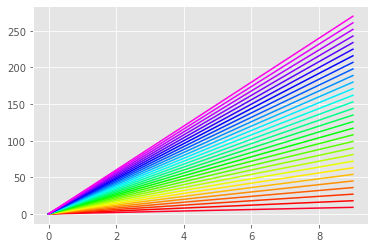

In [139]:
import matplotlib.pyplot as plt
import numpy as np

NUM_COLORS = 30

cm = plt.get_cmap('gist_rainbow')

fig = plt.figure()
ax = fig.add_subplot(111)

# ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

colorList = np.zeros((NUM_COLORS,4))

for i in range(NUM_COLORS):
    p=ax.plot(np.arange(10)*(i+1))
    colorList[i,:] = p[0].get_color() # 'b'

In [140]:
with open('Features.pkl', 'rb') as fn:
    fea = pickle.load(fn)
    
fea.shape    

torch.Size([1428, 2048])

In [206]:
lowResolution = 64

with open('patch.pkl', 'rb') as fn:
    patches = pickle.load(fn)

patchList = patches['patchList']
patchList = np.array(patchList)
labelList = patches['labelList']
labelList = np.asarray(labelList)

patchList = torch.from_numpy(patchList).type(torch.float)
patchList = patchList.unsqueeze(1)
patchList = F.interpolate(patchList, size=(lowResolution, lowResolution), mode='bilinear')
patchList = patchList.squeeze()
patchList.shape

torch.Size([1428, 64, 64])

(-0.5, 1919.5, 1919.5, -0.5)

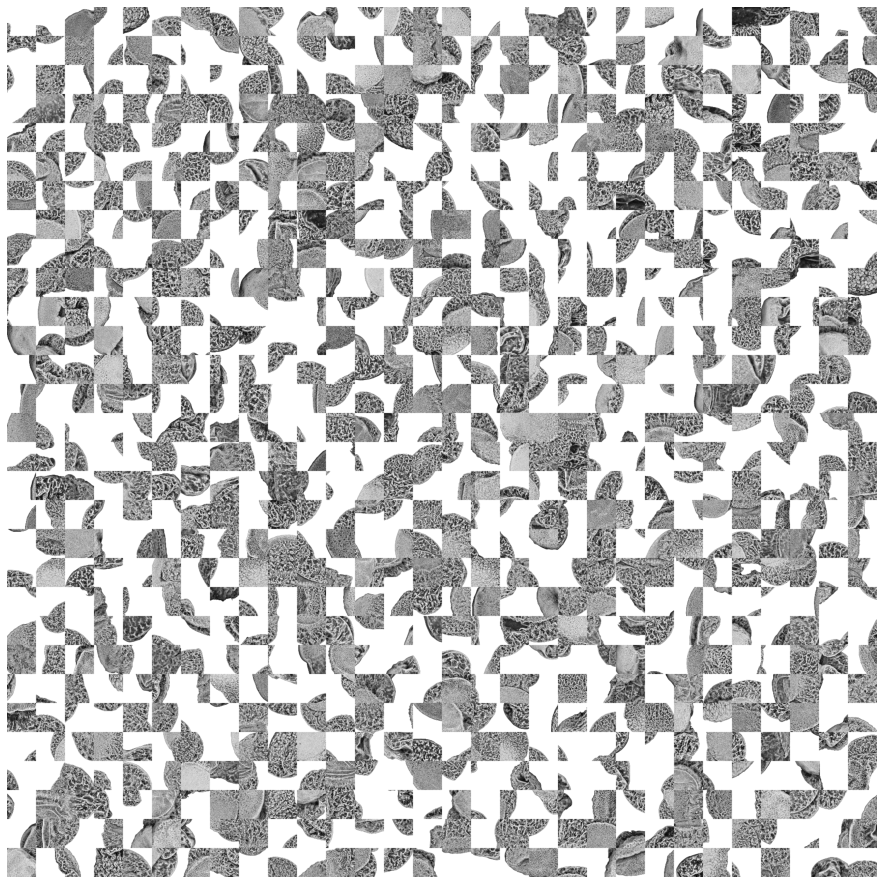

In [207]:
n = 900
tmp = patchList[:n]
arr = np.arange(n)
np.random.shuffle(arr)
tmp = tmp[arr]

tmp = createMontage(tmp, (lowResolution, lowResolution, n), times2rot90=0)

fig, ax = plt.subplots(figsize=(16, 16))
plt.imshow(tmp, cmap='gray')
plt.axis('off')

In [144]:
from sklearn.decomposition import PCA
pcaFunc = PCA(n_components=2)

X =  fea
a = np.linalg.norm(X, 2, axis=1).reshape(-1,1)
X = X/a

MEAN = X.mean(0)
X -= MEAN

pcaFunc.fit(X)

YY = pcaFunc.transform(X)
YY.shape

labelList 

fig, ax = plt.subplots()
for curCls in range(1,30):
    a = np.where(labelList==curCls)
    if len(a[0])==0: continue
    curClsData = YY[a[0],:]
    #ax.scatter(curClsData[:,0], curClsData[:,1], c=rgb_cycle[curCls].reshape(1,-1), label='[open] mnist (class={})'.format(curCls-1))
    ax.scatter(curClsData[:,0], curClsData[:,1], c=colorList[curCls].reshape(1,-1), label='[open] mnist (class={})'.format(curCls-1))



In [149]:
Yorg = tsne(fea.numpy(), 2, 50, 20.0)
Y = Yorg
Y[:,0] = Y[:,0]/max(abs(Y[:,0]))*20
Y[:,1] = Y[:,1]/max(abs(Y[:,1]))*20

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1428...
Computing P-values for point 500 of 1428...
Computing P-values for point 1000 of 1428...
Mean value of sigma: 6.828926
Iteration 200: error is 0.999759
Iteration 400: error is 0.862460
Iteration 600: error is 0.841661
Iteration 800: error is 0.833620
Iteration 1000: error is 0.829715


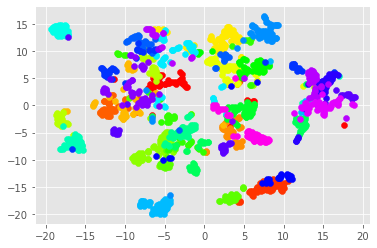

In [156]:
fig, ax = plt.subplots()
for curCls in range(1, 120):
    a = np.where(labelList==curCls)
    if len(a[0])==0: continue
    curClsData = Y[a[0],:]
    ax.scatter(curClsData[:,0], curClsData[:,1], color=colorList[curCls])

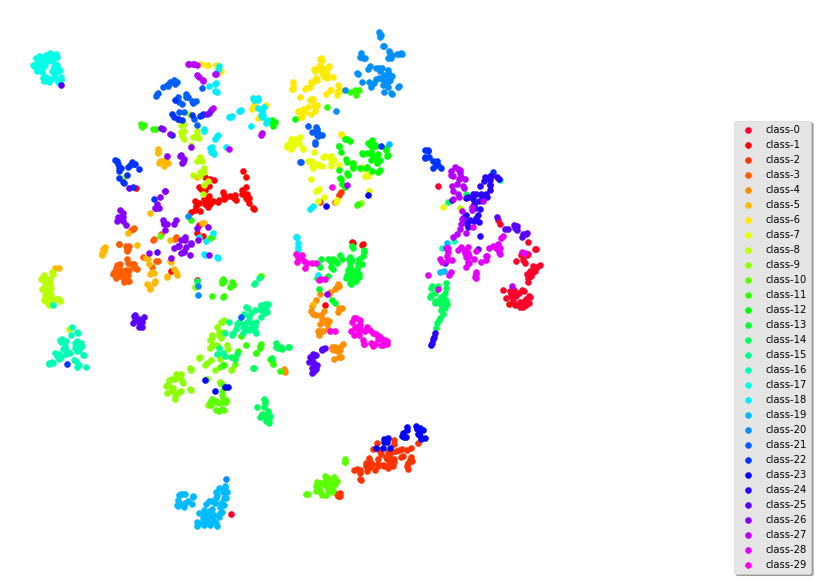

In [159]:
fig, ax = plt.subplots(figsize=(10, 10))

for curCls in range(30):
    a = np.where(labelList==curCls)
    if len(a[0])==0: continue
    curClsData = Yorg[a[0],:]
    ax.scatter(curClsData[:,0], curClsData[:,1], color=colorList[curCls], label='class-{}'.format(curCls))
    
    
plt.axis('off')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)    

In [208]:
frameWidth = 5label_selected
patchList_withFrame = np.zeros((patchList.shape[0],patchList.shape[1],patchList.shape[2],3))
labelList.shape, patchList_withFrame.shape

((1428,), (1428, 64, 64, 3))

In [209]:
for i in range(patchList.shape[0]):    
    tmpImg = patchList[i]
    tmpImg = np.expand_dims(tmpImg, 2)
    tmpImg = np.repeat(tmpImg, 3, axis=2)
    tmpLab = labelList[i]
    tmpCol = colorList[tmpLab]*255
    tmpImg[:frameWidth, :, 0] = tmpCol[0]
    tmpImg[-frameWidth:, :, 0] = tmpCol[0]
    tmpImg[:, :frameWidth, 0] = tmpCol[0]
    tmpImg[:, -frameWidth:, 0] = tmpCol[0]
    tmpImg[:frameWidth, :, 1] = tmpCol[1]
    tmpImg[-frameWidth:, :, 1] = tmpCol[1]
    tmpImg[:, :frameWidth, 1] = tmpCol[1]
    tmpImg[:, -frameWidth:, 1] = tmpCol[1]
    tmpImg[:frameWidth, :, 2] = tmpCol[2]
    tmpImg[-frameWidth:, :, 2] = tmpCol[2]
    tmpImg[:, :frameWidth, 2] = tmpCol[2]
    tmpImg[:, -frameWidth:, 2] = tmpCol[2]
    
    patchList_withFrame[i,:,:] = tmpImg

patchList_withFrame /= 255

(-21.376335596894357,
 21.970301695090207,
 -21.822311140326615,
 18.26853394685894)

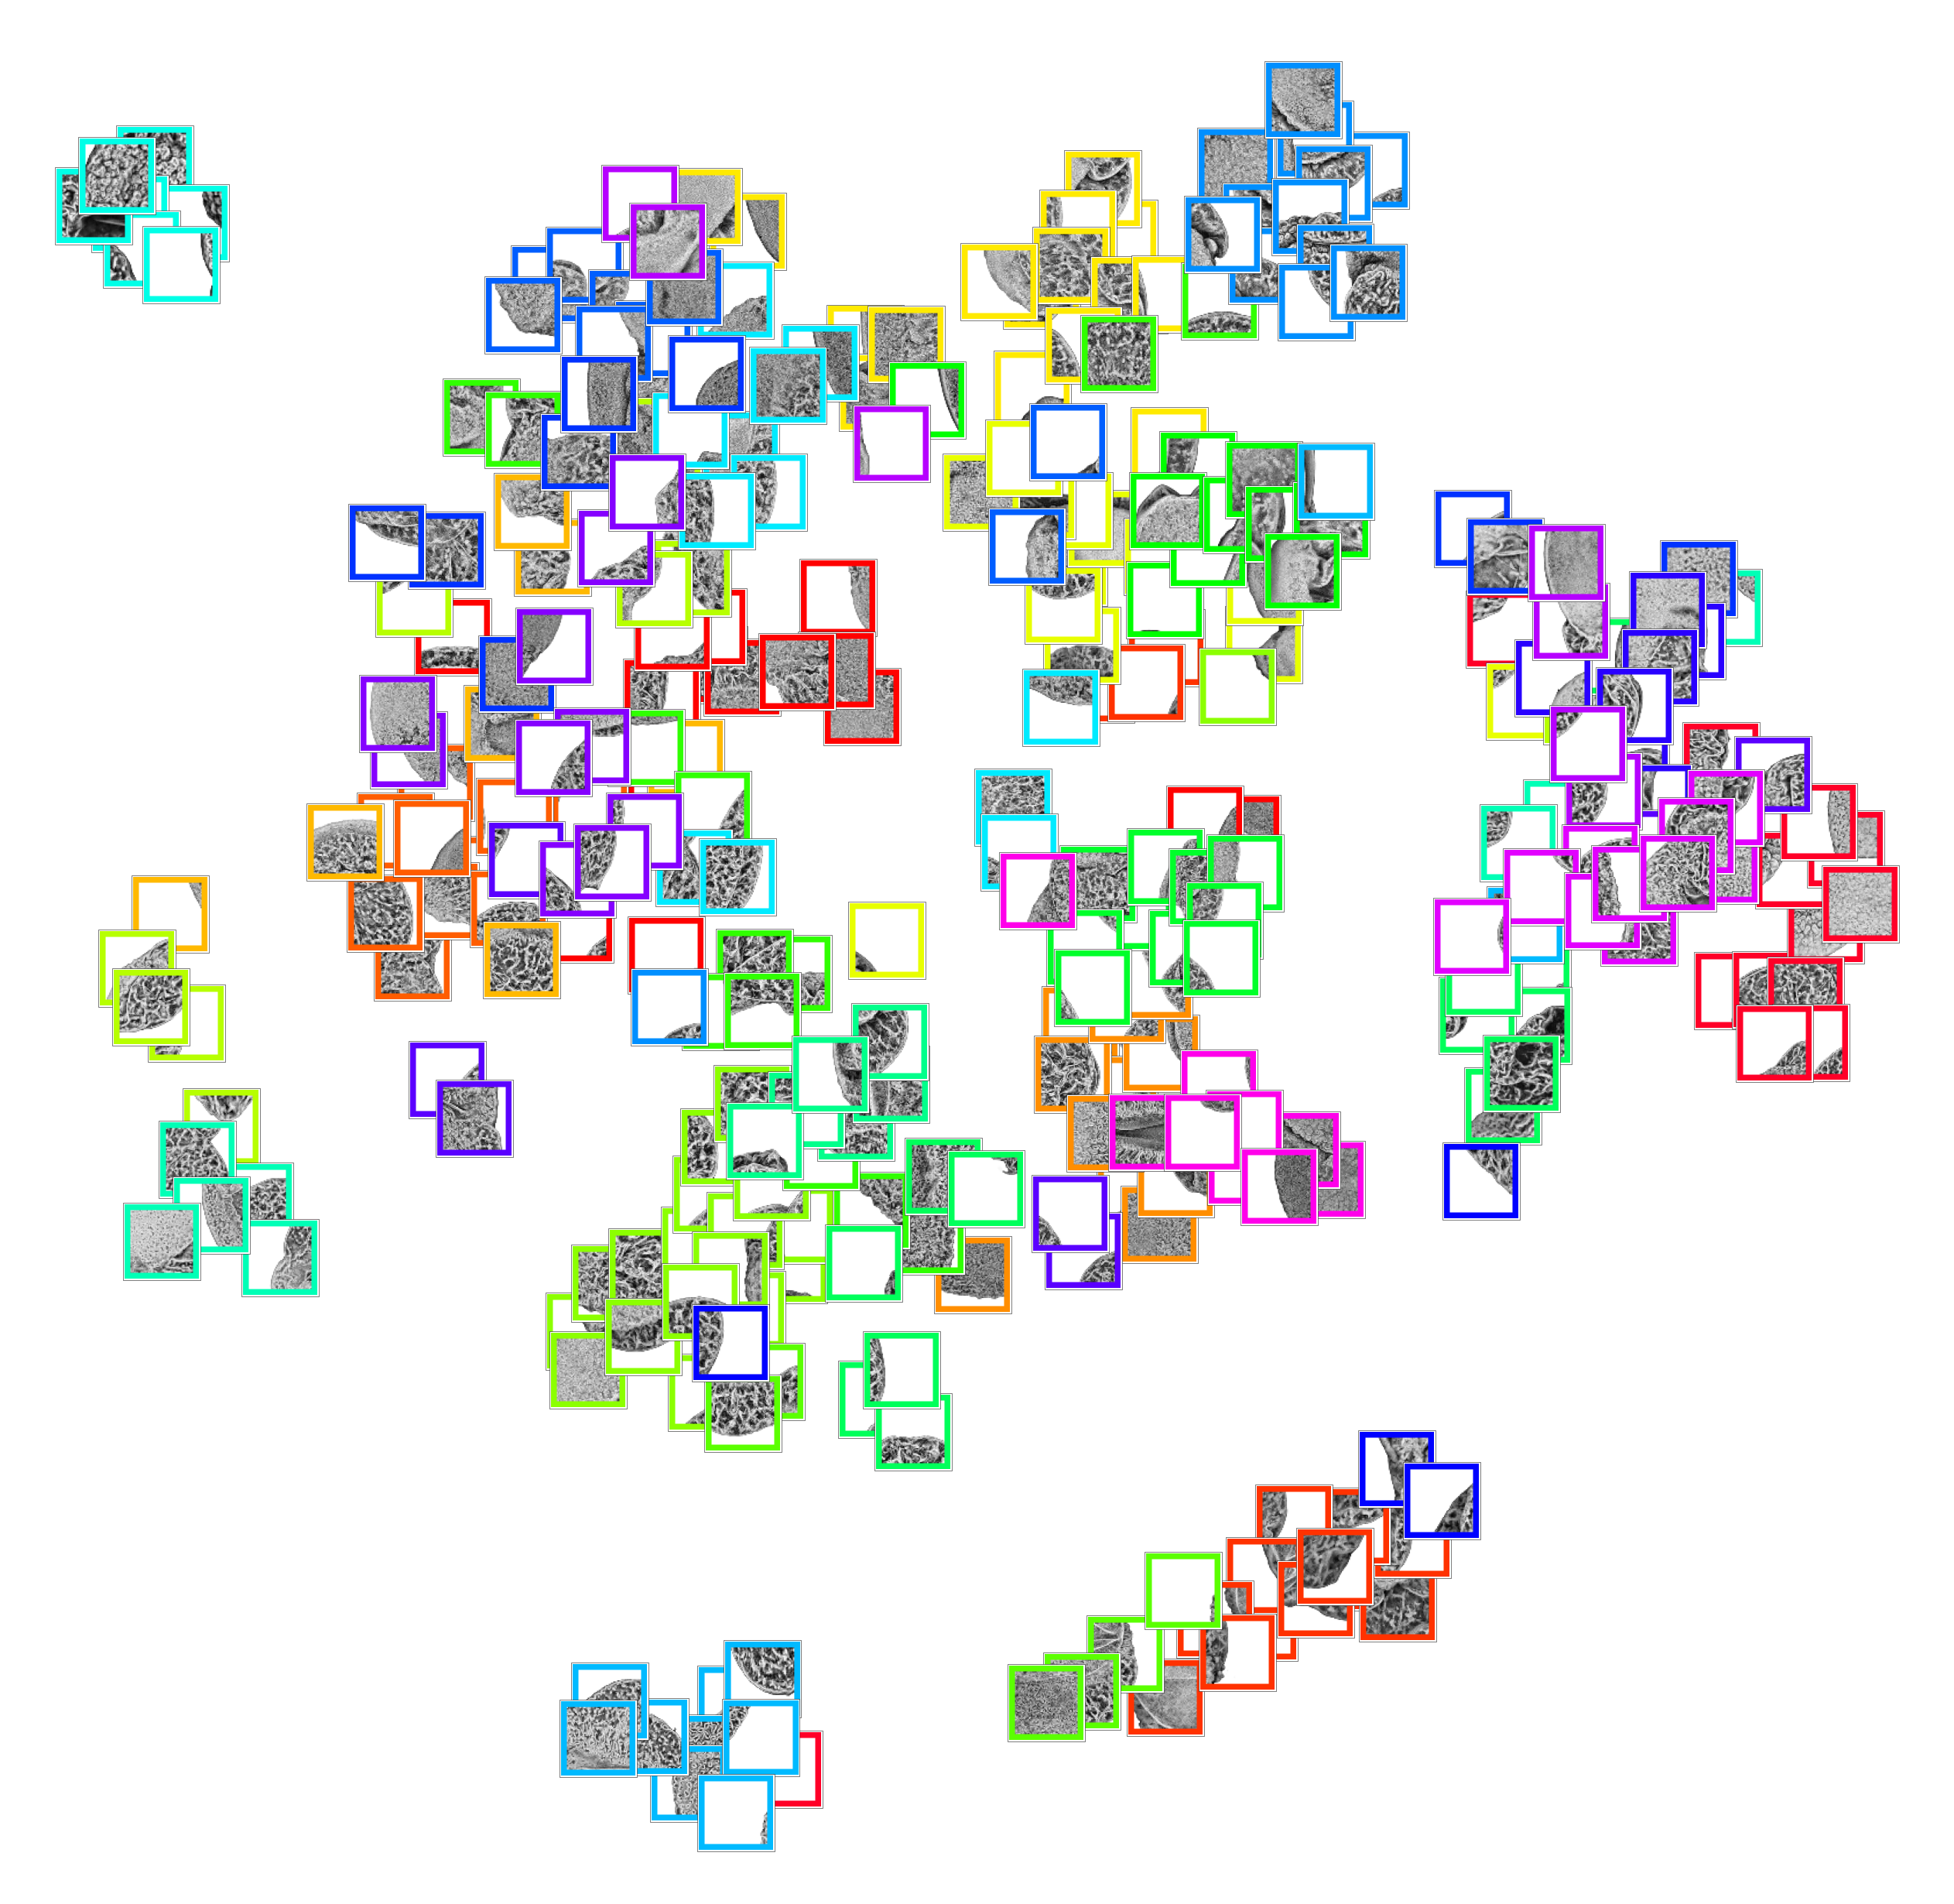

In [210]:
fig, ax = plt.subplots(figsize=(45, 45))

# Y = np.flip(Y,axis=1)
plot_components(fea, Y, 
                images=patchList_withFrame,
                thumb_frac=0.02)
plt.axis('off')
# plt.savefig('tsne.png',bbox_inches='tight',transparent=True)

# remove patches which have large white regions

In [327]:
lowResolution = 64

with open('patch.pkl', 'rb') as fn:
    patches = pickle.load(fn)

patchList = patches['patchList']
patchList = np.array(patchList)
labelList = patches['labelList']
labelList = np.asarray(labelList)

patchList = torch.from_numpy(patchList).type(torch.float)
patchList = patchList.unsqueeze(1)
patchList = F.interpolate(patchList, size=(lowResolution, lowResolution), mode='bilinear')
patchList = patchList.squeeze()

In [328]:
patchList_selected = torch.tensor([])
feature_selected = torch.tensor([])
label_selected = []
for i in range(patchList.shape[0]):
    tmp = patchList[i].type(torch.float).clone()
    tmp[tmp==255] = -1
    tmp[tmp!=-1] = 0
    tmp+=1
    total_area = tmp.shape[0] * tmp.shape[1]
    foreground_area = tmp.sum()
    ratio = foreground_area / total_area
    if ratio>0.7:
        patchList_selected = torch.cat((patchList_selected, patchList[i].unsqueeze(0)), 0) 
        feature_selected = torch.cat((feature_selected, fea[i].unsqueeze(0)), 0)  
        label_selected.append(labelList[i])
label_selected = np.array(label_selected)

(-0.5, 1023.5, 1023.5, -0.5)

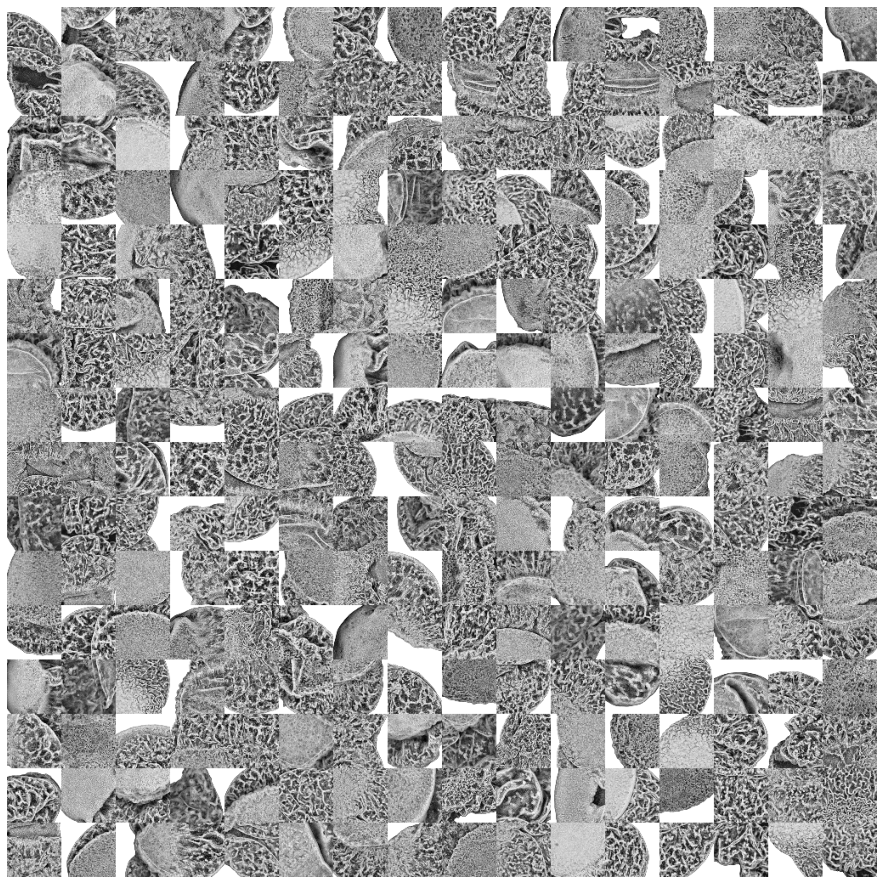

In [329]:
n = 256
tmp = patchList_selected[:n]
arr = np.arange(n)
np.random.shuffle(arr)
tmp = tmp[arr]

tmp = createMontage(tmp, (lowResolution, lowResolution, n), times2rot90=0)

fig, ax = plt.subplots(figsize=(16, 16))
plt.imshow(tmp, cmap='gray')
plt.axis('off')

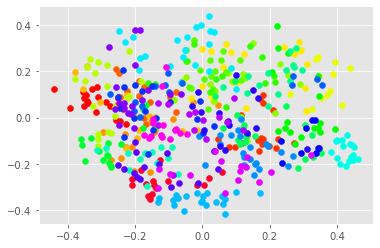

In [331]:
from sklearn.decomposition import PCA
pcaFunc = PCA(n_components=2)

X =  feature_selected
a = np.linalg.norm(X, 2, axis=1).reshape(-1,1)
X = X/a

MEAN = X.mean(0)
X -= MEAN

pcaFunc.fit(X)

YY = pcaFunc.transform(X)
YY.shape

labelList 

fig, ax = plt.subplots()
for curCls in range(30):
    a = np.where(label_selected==curCls)
    if len(a[0])==0: continue
    curClsData = YY[a[0],:]
    #ax.scatter(curClsData[:,0], curClsData[:,1], c=rgb_cycle[curCls].reshape(1,-1), label='[open] mnist (class={})'.format(curCls-1))
    ax.scatter(curClsData[:,0], curClsData[:,1], c=colorList[curCls].reshape(1,-1), label='[open] mnist (class={})'.format(curCls-1))



In [332]:
Yorg = tsne(feature_selected.numpy(), 2, 50, 20.0)
Y = Yorg
Y[:,0] = Y[:,0]/max(abs(Y[:,0]))*20
Y[:,1] = Y[:,1]/max(abs(Y[:,1]))*20

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 495...
Mean value of sigma: 9.872297
Iteration 200: error is 0.434993
Iteration 400: error is 0.414022
Iteration 600: error is 0.411329
Iteration 800: error is 0.410326
Iteration 1000: error is 0.409719


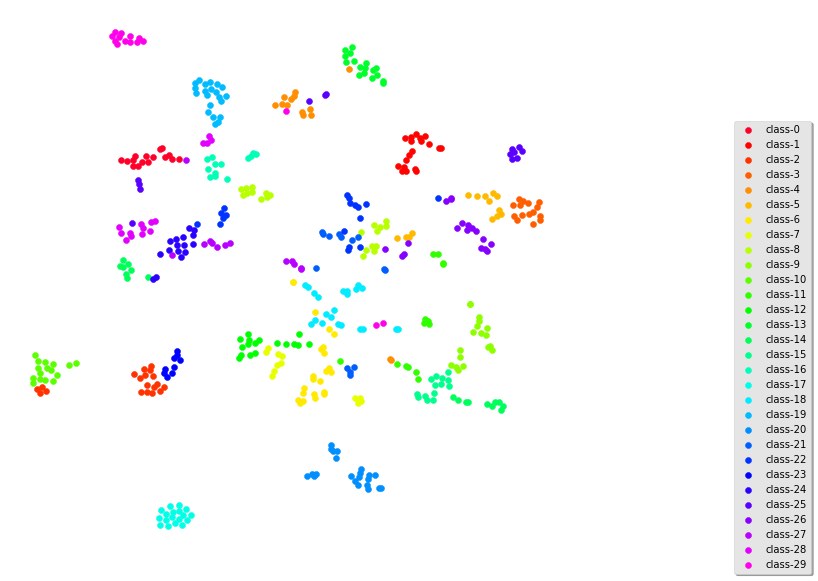

In [333]:
fig, ax = plt.subplots(figsize=(10, 10))

for curCls in range(30):
    a = np.where(label_selected==curCls)
    if len(a[0])==0: continue
    curClsData = Yorg[a[0],:]
    ax.scatter(curClsData[:,0], curClsData[:,1], color=colorList[curCls], label='class-{}'.format(curCls))
    
    
plt.axis('off')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)    

In [335]:
frameWidth = 5
patchList_withFrame = np.zeros((patchList_selected.shape[0],patchList_selected.shape[1],patchList_selected.shape[2],3))
label_selected.shape, patchList_withFrame.shape

((495,), (495, 64, 64, 3))

In [336]:
for i in range(patchList_selected.shape[0]):    
    tmpImg = patchList_selected[i]
    tmpImg = np.expand_dims(tmpImg, 2)
    tmpImg = np.repeat(tmpImg, 3, axis=2)
    tmpLab = label_selected[i]
    tmpCol = colorList[tmpLab]*255
    tmpImg[:frameWidth, :, 0] = tmpCol[0]
    tmpImg[-frameWidth:, :, 0] = tmpCol[0]
    tmpImg[:, :frameWidth, 0] = tmpCol[0]
    tmpImg[:, -frameWidth:, 0] = tmpCol[0]
    tmpImg[:frameWidth, :, 1] = tmpCol[1]
    tmpImg[-frameWidth:, :, 1] = tmpCol[1]
    tmpImg[:, :frameWidth, 1] = tmpCol[1]
    tmpImg[:, -frameWidth:, 1] = tmpCol[1]
    tmpImg[:frameWidth, :, 2] = tmpCol[2]
    tmpImg[-frameWidth:, :, 2] = tmpCol[2]
    tmpImg[:, :frameWidth, 2] = tmpCol[2]
    tmpImg[:, -frameWidth:, 2] = tmpCol[2]
    
    patchList_withFrame[i,:,:] = tmpImg

patchList_withFrame /= 255

(-21.89595774121056, 19.81511256542175, -21.919874484879493, 20.31736418246937)

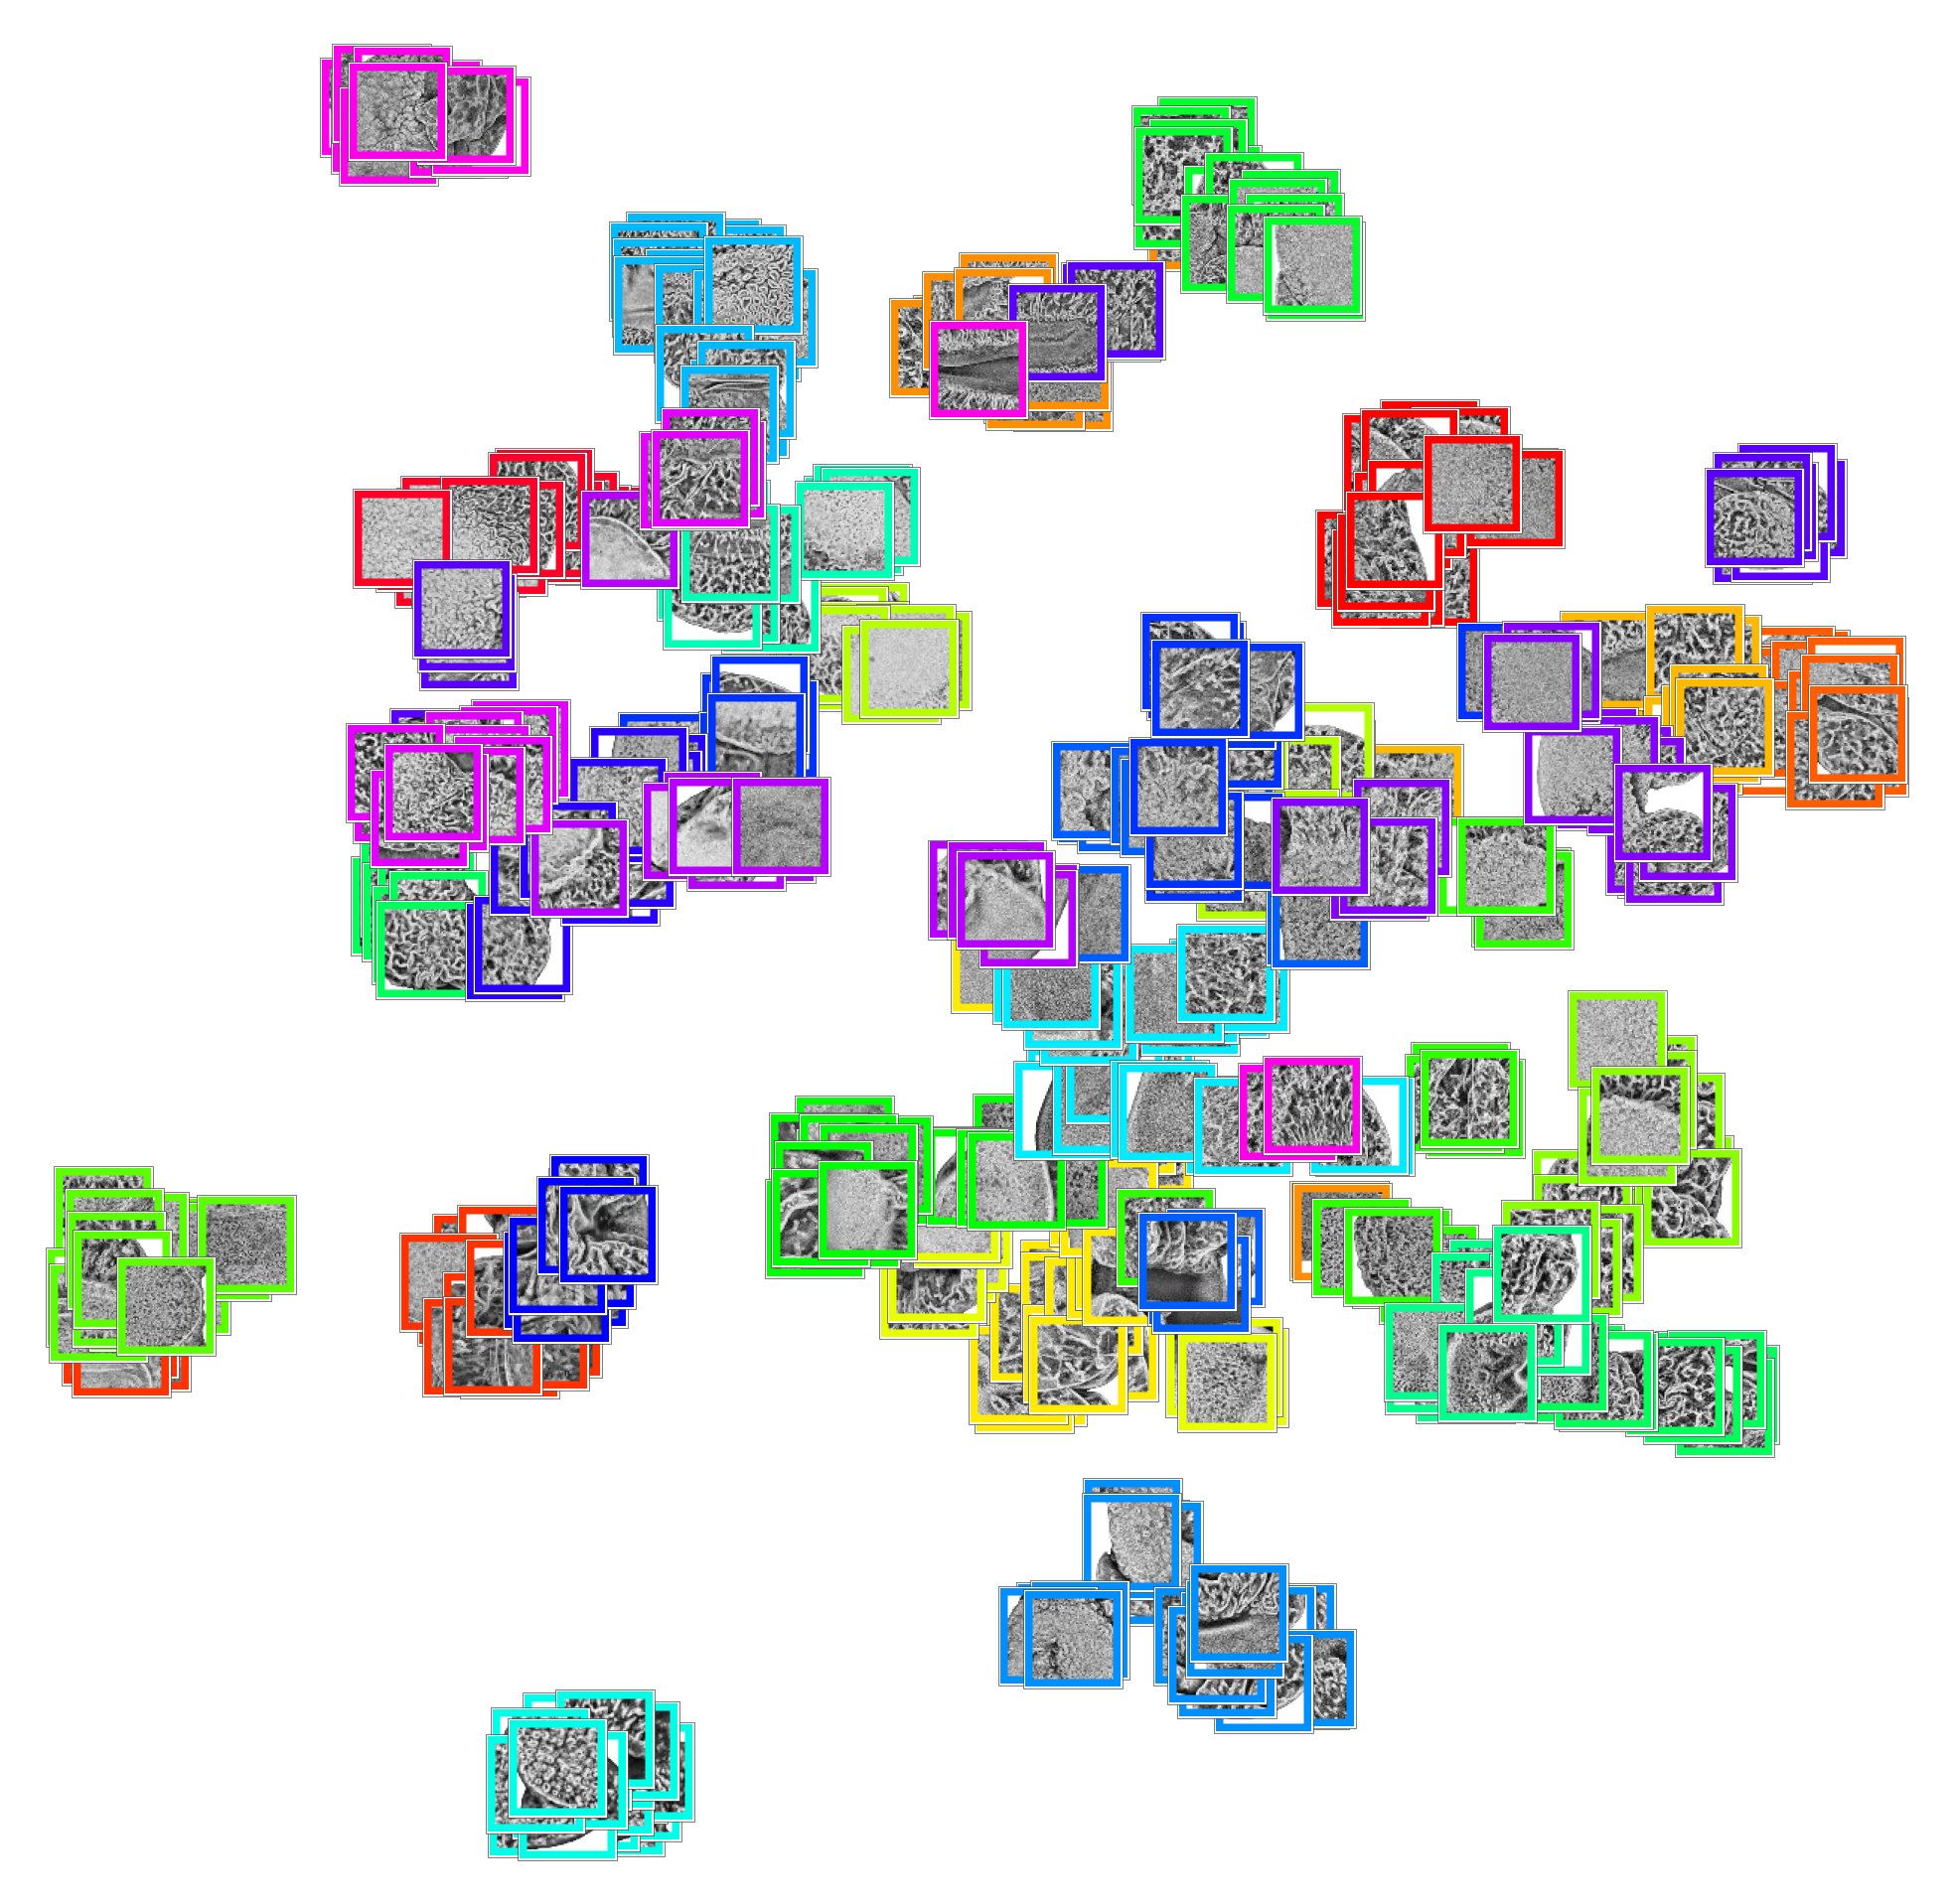

In [347]:
fig, ax = plt.subplots(figsize=(35, 35))

# Y = np.flip(Y,axis=1)
plot_components(feature_selected, Y, 
                images=patchList_withFrame,
                thumb_frac=0.001)
plt.axis('off')
# plt.savefig('tsne.png',bbox_inches='tight',transparent=True)

# leaving blank